In [0]:
! pip install python-igraph
import re 
import itertools
import operator
import copy
import igraph
import heapq
import nltk
# requires nltk 3.2.1
nltk.download('maxent_treebank_pos_tagger')
nltk.download('stopwords')
from nltk import pos_tag # nltk.download('maxent_treebank_pos_tagger')

def clean_text_simple(text, my_stopwords, punct, remove_stopwords=True, pos_filtering=True, stemming=True):
    text = text.lower()
    text = ''.join(l for l in text if l not in punct) # remove punctuation (preserving intra-word dashes)
    text = re.sub(' +',' ',text) # strip extra white space
    text = text.strip() # strip leading and trailing white space
    tokens = text.split(' ') # tokenize (split based on whitespace)
    if pos_filtering == True:
        # POS-tag and retain only nouns and adjectives
        tagged_tokens = pos_tag(tokens)
        tokens_keep = []
        for item in tagged_tokens:
            if (
            item[1] == 'NN' or
            item[1] == 'NNS' or
            item[1] == 'NNP' or
            item[1] == 'NNPS' or
            item[1] == 'JJ' or
            item[1] == 'JJS' or
            item[1] == 'JJR'
            ):
                tokens_keep.append(item[0])
        tokens = tokens_keep
    if remove_stopwords:
        tokens = [token for token in tokens if token not in my_stopwords]
    if stemming:
        stemmer = nltk.stem.PorterStemmer()
        tokens_stemmed = list()
        for token in tokens:
            tokens_stemmed.append(stemmer.stem(token))
        tokens = tokens_stemmed
    
    return(tokens)


def terms_to_graph(terms, window_size):
    '''This function returns a directed, weighted igraph from lists of list of terms (the tokens from the pre-processed text)
    e.g., ['quick','brown','fox']
    Edges are weighted based on term co-occurence within a sliding window of fixed size 'w'
    '''
    
    from_to = {}

    w = min(window_size, len(terms))
    # create initial complete graph (first w terms)
    terms_temp = terms[0:w]
    indexes = list(itertools.combinations(range(w), r=2))

    new_edges = []

    for my_tuple in indexes:
        new_edges.append(tuple([terms_temp[i] for i in my_tuple]))
    for new_edge in new_edges:
        if new_edge in from_to:
            from_to[new_edge] += 1
        else:
            from_to[new_edge] = 1

    # then iterate over the remaining terms
    for i in range(w, len(terms)):
        # term to consider
        considered_term = terms[i]
        # all terms within sliding window
        terms_temp = terms[(i - w + 1):(i + 1)]

        # edges to try
        candidate_edges = []
        for p in range(w - 1):
            candidate_edges.append((terms_temp[p], considered_term))

        for try_edge in candidate_edges:

            # if not self-edge
            if try_edge[1] != try_edge[0]:

                # if edge has already been seen, update its weight
                if try_edge in from_to:
                    from_to[try_edge] += 1

                # if edge has never been seen, create it and assign it a unit weight
                else:
                    from_to[try_edge] = 1

    # create empty graph
    g = igraph.Graph(directed=True)

    # add vertices
    g.add_vertices(sorted(set(terms)))

    # add edges, direction is preserved since the graph is directed
    g.add_edges(list(from_to.keys()))

    # set edge and vertice weights
    g.es['weight'] = list(from_to.values()) # based on co-occurence within sliding window
    g.vs['weight'] = g.strength(weights=list(from_to.values())) # weighted degree

    return (g)

     |████████████████████████████████| 378kB 2.7MB/s 
  Created wheel for python-igraph: filename=python_igraph-0.7.1.post6-cp36-cp36m-linux_x86_64.whl size=2219402 sha256=3ecbe3a80ba7499ff57be8d71df38c86bc4228c7a8cc28d0c705dcfbfed47b7b
  Stored in directory: /root/.cache/pip/wheels/41/d6/02/34eebae97e25f5b87d60f4c0687e00523e3f244fa41bc3f4a7
Successfully built python-igraph
[nltk_data] Downloading package maxent_treebank_pos_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/maxent_treebank_pos_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
from nltk.corpus import stopwords
import string

nltk.download('averaged_perceptron_tagger')

stpwds = stopwords.words('english')
punct = string.punctuation.replace('-', '')

my_doc = 'A method for solution of systems of linear algebraic equations \
with m-dimensional lambda matrices. A system of linear algebraic \
equations with m-dimensional lambda matrices is considered. \
The proposed method of searching for the solution of this system \
lies in reducing it to a numerical system of a special kind.'

my_doc = my_doc.replace('\n', '')

# pre-process document
my_tokens = clean_text_simple(my_doc,my_stopwords=stpwds,punct=punct)

g = terms_to_graph(my_tokens, 4)

# number of edges
print(len(g.es))

# the number of nodes should be equal to the number of unique terms
print(len(g.vs) == len(set(my_tokens)))

edge_weights = []
for edge in g.es:
    source = g.vs[edge.source]['name']
    target = g.vs[edge.target]['name']
    weight = edge['weight']
    edge_weights.append([source, target, weight])

print(edge_weights)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
42
True
[['method', 'solut', 2], ['method', 'system', 2], ['method', 'linear', 1], ['solut', 'system', 3], ['solut', 'linear', 1], ['system', 'linear', 2], ['solut', 'algebra', 1], ['system', 'algebra', 2], ['linear', 'algebra', 2], ['system', 'equat', 2], ['linear', 'equat', 2], ['algebra', 'equat', 2], ['linear', 'm-dimension', 2], ['algebra', 'm-dimension', 2], ['equat', 'm-dimension', 2], ['algebra', 'lambda', 2], ['equat', 'lambda', 2], ['m-dimension', 'lambda', 2], ['equat', 'system', 1], ['m-dimension', 'system', 1], ['lambda', 'system', 1], ['m-dimension', 'linear', 1], ['lambda', 'linear', 1], ['lambda', 'algebra', 1], ['equat', 'matric', 1], ['m-dimension', 'matric', 1], ['lambda', 'matric', 1], ['m-dimension', 'method', 1], ['lambda', 'method', 1], ['matric', 'method', 1], ['lambda', 'solut

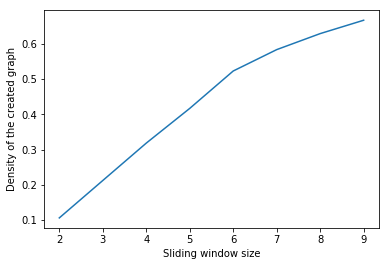

In [0]:
import matplotlib.pyplot as plt

densities = []
W = range(2,10)
for w in W:
    g = terms_to_graph(my_tokens, w)
    densities.append(g.density())

plt.plot(W,densities)
plt.xlabel('Sliding window size')
plt.ylabel('Density of the created graph')
plt.show()

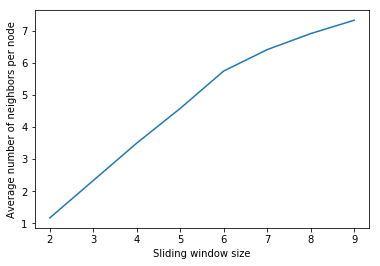

In [0]:
densities = []
W = range(2,10)
for w in W:
    g = terms_to_graph(my_tokens, len(my_tokens))
    densities.append(g.density()*(len(g.vs())-1))

plt.plot(W,densities)
plt.xlabel('Sliding window size')
plt.ylabel('Average number of neighbors per node')
plt.show()

In [0]:
edge_weights = []
for edge in g.es:
    source = g.vs[edge.source]['name']
    target = g.vs[edge.target]['name']
    weight = edge['weight']
    edge_weights.append([source, target, weight])

print(edge_weights)

[['solut', 'system', 3], ['solut', 'linear', 1], ['system', 'linear', 2], ['solut', 'algebra', 1], ['system', 'algebra', 2], ['linear', 'algebra', 2], ['system', 'equat', 2], ['linear', 'equat', 2], ['algebra', 'equat', 2], ['linear', 'm-dimension', 2], ['algebra', 'm-dimension', 2], ['equat', 'm-dimension', 2], ['algebra', 'lambda', 2], ['equat', 'lambda', 2], ['m-dimension', 'lambda', 2], ['equat', 'system', 1], ['m-dimension', 'system', 1], ['lambda', 'system', 1], ['m-dimension', 'linear', 1], ['lambda', 'linear', 1], ['lambda', 'algebra', 1], ['equat', 'matric', 1], ['m-dimension', 'matric', 1], ['lambda', 'matric', 1], ['lambda', 'solut', 1], ['matric', 'solut', 1], ['matric', 'system', 1], ['solut', 'numer', 1], ['system', 'numer', 1], ['numer', 'system', 1], ['system', 'special', 2], ['numer', 'special', 1], ['numer', 'kind', 1], ['system', 'kind', 1], ['special', 'kind', 1]]


In [0]:
def core_dec(g,weighted):
    '''(un)weighted k-core decomposition'''
    # work on clone of g to preserve g 
    gg = copy.deepcopy(g)
    if not weighted:
        gg.vs['weight'] = gg.strength() # overwrite the 'weight' vertex attribute with the unweighted degrees
    # initialize dictionary that will contain the core numbers
    cores_g = dict(zip(gg.vs['name'],[0]*len(gg.vs)))
    
    while len(gg.vs) > 0:
        # find index of lowest degree vertex
        min_degree = min(gg.vs['weight'])
        index_top = gg.vs['weight'].index(min_degree)
        name_top = gg.vs[index_top]['name']
        # get names of its neighbors
        neighbors = gg.vs[gg.neighbors(index_top)]['name']
        # exclude self-edges
        neighbors = [elt for elt in neighbors if elt!=name_top]
        # set core number of lowest degree vertex as its degree
        cores_g[name_top] = min_degree
        gg.delete_vertices(name_top)
        ### fill the gap (delete top vertex and its incident edges) ###
        
        if neighbors:
            if weighted: 
                new_degrees = gg.strength(weights = list(gg.es["weight"]))
                ### fill the gap (compute the new weighted degrees, save results as 'new_degrees')
            else:
                ### fill the gap (same as above but for the basic degree) ###
                new_degrees = gg.strength()
            # iterate over neighbors of top element
            for neigh in neighbors:
                index_n = gg.vs['name'].index(neigh)
                gg.vs[index_n]['weight'] = max(min_degree,new_degrees[index_n])  
        
    return(cores_g)


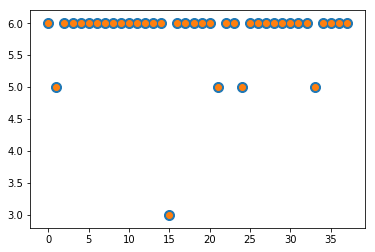

In [0]:
import matplotlib.pyplot as plt

core_numbers = core_dec(g,False)
plt.scatter(range(len(core_numbers)),g.coreness(), s = 100)
plt.scatter(range(len(core_numbers)),core_numbers.values())


In [0]:
def accuracy_metrics(candidate, truth):
    # true positives ('hits') are both in candidate and in truth
    tp = len(set(candidate).intersection(truth))
    
    # false positives a.k.a. false alarms are in candidate but not in truth
    fp = len([element for element in candidate if element not in truth])
    
    ### fill the gap (compute false negatives a.k.a. misses, save results as 'fn')
    fn = len([element for element in truth if element not in candidate])
    
    ### fill the gaps (compute precision and recall as a function of 'tp', 'fp' and 'fn', save results as 'prec' and 'rec') ###
    
    prec = tp/(tp+fp)
    
    rec = tp/(tp+fn)
    
    if prec+rec != 0:
        f1 = 2*prec*rec/(prec+rec)
    else:
        f1 = 0
    
    return (prec, rec, f1)


In [0]:
import os
import string
import re 
import operator
import nltk
from nltk.corpus import stopwords
from google.colab import drive

from sklearn.feature_extraction.text import TfidfVectorizer


stemmer = nltk.stem.PorterStemmer()
stpwds = stopwords.words('english')
punct = string.punctuation.replace('-', '')

# Montage du Drive Google

drive.mount("/content/drive")

# Mise en Place du répertoire de travail

path_to_folder = "/content/drive/My Drive/Colab Notebooks"
os.chdir(path_to_folder)
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
'20191010_DL1_20192020_Lab_keras_imdb_students (1).ipynb'
 20191010_DL1_20192020_Lab_keras_imdb_students.ipynb
 AlteGrad_TP1_ABBOUDI.ipynb
 ANN_PARAMETRES_DE_MARCHE.ipynb
 Backpropagation_numpy.ipynb
 data
 dl_notebook1_python.ipynb
 dl_notebook2_pytorch.ipynb
'DS_Deep_lab1_1 (1).ipynb'
 DS_Deep_lab1_2.ipynb
 image_captioning_0.ipynb
 ImageClassification.ipynb
 lab1_MLP.ipynb
 lab2_MLP.ipynb
 Untitled0.ipynb
 Untitled1.ipynb
 Untitled2.ipynb
 Untitled3.ipynb


In [0]:
##################################
# read and pre-process abstracts #
##################################

path_to_abstracts = 'data/Hulth2003testing/abstracts/'
abstract_names = sorted(os.listdir(path_to_abstracts))

abstracts = []
for counter,filename in enumerate(abstract_names):
    # read file
    with open(path_to_abstracts + '/' + filename, 'r') as my_file: 
        text = my_file.read().splitlines()
    text = ' '.join(text)
    # remove formatting
    text = re.sub('\s+', ' ', text)
    abstracts.append(text)
    
    if counter % round(len(abstract_names)/5) == 0:
        print(counter, 'files processed')

abstracts_cleaned = []
for counter,abstract in enumerate(abstracts):
    my_tokens = clean_text_simple(abstract,my_stopwords=stpwds,punct=punct)
    abstracts_cleaned.append(my_tokens)
    
    if counter % round(len(abstracts)/5) == 0:
        print(counter, 'abstracts processed')

0 files processed
100 files processed
200 files processed
300 files processed
400 files processed
0 abstracts processed
100 abstracts processed
200 abstracts processed
300 abstracts processed
400 abstracts processed


In [0]:
kmax = max(core)

max(core_dec(g,False), key=core_dec(g,False).get)
core_dec(g,False)

{'algebra': 6.0,
 'equat': 6.0,
 'kind': 3.0,
 'lambda': 6.0,
 'linear': 6.0,
 'm-dimension': 6.0,
 'matric': 6.0,
 'method': 6.0,
 'numer': 4.0,
 'solut': 6.0,
 'special': 3.0,
 'system': 6.0}

In [0]:




###############################################
# read and pre-process gold standard keywords #
###############################################

path_to_keywords = 'data/Hulth2003testing/uncontr/'
keywd_names = sorted(os.listdir(path_to_keywords))
   
keywds_gold_standard = []

for counter,filename in enumerate(keywd_names):
    # read file
    with open(path_to_keywords + filename, 'r') as my_file: 
        text = my_file.read().splitlines()
    text = ' '.join(text)
    text =  re.sub('\s+', ' ', text) # remove formatting
    text = text.lower()
    # turn string into list of keywords, preserving intra-word dashes 
    # but breaking n-grams into unigrams
    keywds = text.split(';')
    keywds = [keywd.strip().split(' ') for keywd in keywds]
    keywds = [keywd for sublist in keywds for keywd in sublist] # flatten list
    keywds = [keywd for keywd in keywds if keywd not in stpwds] # remove stopwords (rare but may happen due to n-gram breaking)
    keywds_stemmed = [stemmer.stem(keywd) for keywd in keywds]
    keywds_stemmed_unique = list(set(keywds_stemmed)) # remove duplicates (may happen due to n-gram breaking)
    keywds_gold_standard.append(keywds_stemmed_unique)
    
    if counter % round(len(keywd_names)/5) == 0:
        print(counter, 'files processed')

##############################
# precompute graphs-of-words #
##############################

gs = []
for abstr in abstracts_cleaned:
  gs.append(terms_to_graph(abstr,4))

##################################
# graph-based keyword extraction #
##################################

my_percentage = 0.33 # for PR and TF-IDF

method_names = ['kc','wkc','pr','tfidf']
keywords = dict(zip(method_names,[[],[],[],[]]))

for counter,g in enumerate(gs):
    # k-core
    core_numbers = core_dec(g,False)
    kmax = max(core_numbers.values())
    ### fill the gaps (retain main core as keywords and append the resulting list to 'keywords['kc']') ###
    keywords['kc'].append([kw for kw in core_numbers.keys() if core_numbers[kw] == kmax])
    
    # weighted k-core
    ### fill the gaps (repeat the procedure used for k-core) ###
    core_numbers = core_dec(g,True)
    kmax = max(core_numbers.values())
    keywords['wkc'].append([kw for kw in core_numbers.keys() if core_numbers[kw] == kmax])

    
    # PageRank
    pr_scores = zip(g.vs['name'],g.pagerank())
    pr_scores = sorted(pr_scores, key=operator.itemgetter(1), reverse=True) # in decreasing order
    numb_to_retain = int(len(pr_scores)*my_percentage) # retain top 'my_percentage' % words as keywords
    keywords['pr'].append([tuple[0] for tuple in pr_scores[:numb_to_retain]])
        
    if counter % round(len(gs)/5) == 0:
        print(counter)



0 files processed
100 files processed
200 files processed
300 files processed
400 files processed
0
100
200
300
400


In [0]:
#############################
# TF-IDF keyword extraction #
#############################

abstracts_cleaned_strings = [' '.join(elt) for elt in abstracts_cleaned] # to ensure same pre-processing as the other methods
tfidf_vectorizer = TfidfVectorizer(stop_words=stpwds)
doc_term_matrix = tfidf_vectorizer.fit_transform(abstracts_cleaned_strings)

### fill the gap (call the .fit_transform() method and name the result 'doc_term_matrix') ###
terms = tfidf_vectorizer.get_feature_names()
vectors_list = doc_term_matrix.todense().tolist()

for counter,vector in enumerate(vectors_list):
    terms_weights = zip(terms,vector) # bow feature vector as list of tuples
    nonzero = [(kw,tw) for kw, tw in terms_weights if tw!=0]
    ### fill the gap (keep only non zero values, i.e., the words in the document. store the results in a list named 'nonzero') ###
    nonzero = sorted(nonzero, key=operator.itemgetter(1), reverse=True) # in decreasing order
    numb_to_retain = int(len(nonzero)*my_percentage) # retain top 'my_percentage' % words as keywords
    keywords['tfidf'].append([tuple[0] for tuple in nonzero[:numb_to_retain]])
    
    if counter % round(len(vectors_list)/5) == 0:
        print(counter)

##########################
# performance comparison #
##########################

perf = dict(zip(method_names,[[],[],[],[]]))

for idx,truth in enumerate(keywds_gold_standard):
    for mn in method_names:
        ### fill the gap (append to the 'perf[mn]' list by using the 'accuracy_metrics' function) ###
        perf[mn].append(accuracy_metrics(keywords[mn][idx],truth))

lkgs = len(keywds_gold_standard)

# print macro-averaged results (averaged at the collection level)
for k,v in perf.items():
    print(k + ' performance: \n')
    print('precision:', round(100*sum([tuple[0] for tuple in v])/lkgs,2))
    print('recall:', round(100*sum([tuple[1] for tuple in v])/lkgs,2))
    print('F-1 score:', round(100*sum([tuple[2] for tuple in v])/lkgs,2))
    print('\n')

0
100
200
300
400
kc performance: 

precision: 51.86
recall: 62.56
F-1 score: 51.55


wkc performance: 

precision: 63.86
recall: 48.64
F-1 score: 46.52


pr performance: 

precision: 60.18
recall: 38.3
F-1 score: 44.96


tfidf performance: 

precision: 59.21
recall: 38.5
F-1 score: 44.85


